In [4]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import cv2
import detectron2
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os, random, sys
import pandas as pd
import torch

In [32]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from tqdm import tqdm

## Implementing of custom dataset for Detectron2

In [7]:
DATASET_NAME = 'otus_basketball_dataset'

In [8]:
def basketball_dataset_function(dataset_type, dataset_name):
    list_dicts = []
    f = open(f'{dataset_name}/anno_{dataset_type}.json')
    data = json.load(f)
    for image_id, filename in enumerate(data):
        img = cv2.imread(f'{dataset_name}/images_{dataset_type}/{filename}')
        metadata_dict = {}
        metadata_dict['file_name'] = f'{dataset_name}/images_{dataset_type}/{filename}'
        metadata_dict['width'] = img.shape[1]
        metadata_dict['height'] = img.shape[0]
        metadata_dict['image_id'] = image_id
        metadata_dict['annotations'] = []
        
        for player in data[filename]:
            x, y, w, h = data[filename][player]['box']
            x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
            metadata_dict['annotations'].append(
                 {
                  'bbox': [x, y, w, h],
                  'bbox_mode': BoxMode.XYWH_ABS,
                  'category_id': data[filename][player]['team'],
                 }
             )
        list_dicts.append(metadata_dict)
    return list_dicts

In [9]:
for d in ["train", "test"]:
    DatasetCatalog.register("basketball_dataset_" + d, lambda d=d: basketball_dataset_function(d, DATASET_NAME))
    MetadataCatalog.get("basketball_dataset_" + d).set(thing_classes=["team1", "team2"])

## Plotting some examples

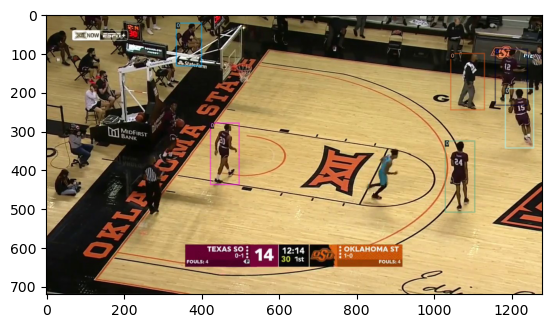

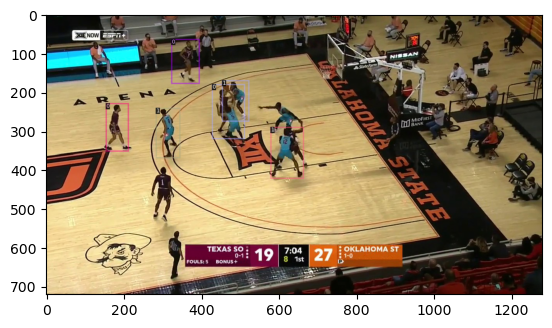

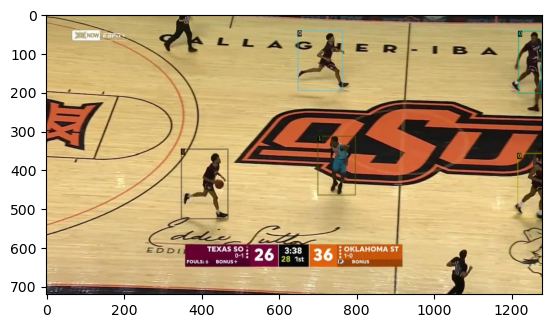

In [10]:
dataset_dicts = basketball_dataset_function('train', DATASET_NAME)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

## Configure and load model

In [11]:
cfg = get_cfg()
cfg.DATASETS.TRAIN = ("basketball_dataset_train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001 
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[01/07 01:03:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[01/07 01:03:24 d2.data.build]: Removed 0 images with no usable annotations. 400 images left.
[01/07 01:03:24 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   team1    | 1378         |   team2    | 1368         |
|            |              |            |              |
|   total    | 2746         |            |              |
[01/07 01:03:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800,), max_size=1333, sample_style='choice'), RandomFlip()]
[01/07 01:03:24 d2.data.build]: Using training sampler TrainingSampler
[01/07 01:03:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[01/07 01:03:24 d2.data.common]: Serializing 400 elements to byte tensors and concatenating them all ...
[01/07 01:03:24 d2.data.common]: Serialized dataset t

2023-01-07 01:03:24.434146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (8, 2048) in the model! You might want to double check if this is expe

# Model training

In [8]:
trainer.train()

[01/05 00:07:04 d2.engine.train_loop]: Starting training from iteration 0


/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/05 00:07:11 d2.utils.events]:  eta: 0:04:51  iter: 19  total_loss: 1.564  loss_cls: 1.122  loss_box_reg: 0.01213  loss_rpn_cls: 0.376  loss_rpn_loc: 0.03767  time: 0.3000  data_time: 0.0066  lr: 1.9981e-06  max_mem: 4916M
[01/05 00:07:17 d2.utils.events]:  eta: 0:04:44  iter: 39  total_loss: 1.463  loss_cls: 1.04  loss_box_reg: 0.0155  loss_rpn_cls: 0.375  loss_rpn_loc: 0.03895  time: 0.2982  data_time: 0.0023  lr: 3.9961e-06  max_mem: 4916M
[01/05 00:07:23 d2.utils.events]:  eta: 0:04:38  iter: 59  total_loss: 1.255  loss_cls: 0.8121  loss_box_reg: 0.01841  loss_rpn_cls: 0.3654  loss_rpn_loc: 0.03827  time: 0.2978  data_time: 0.0025  lr: 5.9941e-06  max_mem: 4916M
[01/05 00:07:29 d2.utils.events]:  eta: 0:04:32  iter: 79  total_loss: 1.012  loss_cls: 0.589  loss_box_reg: 0.03067  loss_rpn_cls: 0.3642  loss_rpn_loc: 0.04089  time: 0.2962  data_time: 0.0025  lr: 7.9921e-06  max_mem: 4916M
[01/05 00:07:34 d2.utils.events]:  eta: 0:04:25  iter: 99  total_loss: 0.8279  loss_cls: 0.3979

[01/05 00:10:34 d2.utils.events]:  eta: 0:01:12  iter: 739  total_loss: 0.8268  loss_cls: 0.2553  loss_box_reg: 0.4986  loss_rpn_cls: 0.04135  loss_rpn_loc: 0.02441  time: 0.2824  data_time: 0.0024  lr: 7.3926e-05  max_mem: 4916M
[01/05 00:10:40 d2.utils.events]:  eta: 0:01:07  iter: 759  total_loss: 0.842  loss_cls: 0.2426  loss_box_reg: 0.5308  loss_rpn_cls: 0.03766  loss_rpn_loc: 0.026  time: 0.2824  data_time: 0.0026  lr: 7.5924e-05  max_mem: 4916M
[01/05 00:10:46 d2.utils.events]:  eta: 0:01:01  iter: 779  total_loss: 0.8062  loss_cls: 0.2371  loss_box_reg: 0.5059  loss_rpn_cls: 0.04032  loss_rpn_loc: 0.02495  time: 0.2823  data_time: 0.0024  lr: 7.7922e-05  max_mem: 4916M
[01/05 00:10:51 d2.utils.events]:  eta: 0:00:55  iter: 799  total_loss: 0.7591  loss_cls: 0.2157  loss_box_reg: 0.5022  loss_rpn_cls: 0.03434  loss_rpn_loc: 0.02361  time: 0.2822  data_time: 0.0023  lr: 7.992e-05  max_mem: 4916M
[01/05 00:10:57 d2.utils.events]:  eta: 0:00:50  iter: 819  total_loss: 0.761  loss_

# Evaluate model

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("basketball_dataset_test", )
predictor = DefaultPredictor(cfg)

In [63]:
test_dataset_dicts = basketball_dataset_function('test', DATASET_NAME)
test_dataset_metadata = MetadataCatalog.get("basketball_dataset_test")

## Custom Lazy Mean IoU score

In [21]:
NUM_CLASSES = 2

def iou_per_class(arr_):   
    unique, counts = np.unique(arr_, return_counts=True)
    dict_counts_uniq = dict(zip(unique.astype(int), counts))
    union = 0
    intersect = 0

    for keys in dict_counts_uniq:
        if keys == 0:
            continue
        else:
            union += dict_counts_uniq[keys]
            if keys == 2:
                intersect += dict_counts_uniq[keys]
    return (intersect / union)

def mean_iou_score(dataset_dicts, predictor, num_classes):
    list_of_iou = []

    for d in dataset_dicts:  
        ## Load Image
        img = cv2.imread(d["file_name"])
        
        canvas_img_gt = np.zeros((img.shape[0], img.shape[1], num_classes))
        canvas_img_pred = np.zeros((img.shape[0], img.shape[1], num_classes))
        
        ## Calculate preds
        outputs = predictor(img)

        for obj in d['annotations']:
            x, y, w, h  = obj['bbox']
            x1, y1, x2, y2 = x,y, x+w,y+h
            canvas_img_gt[y1:y2, x1:x2, obj['category_id']] = 1

        pred_bboxes = outputs["instances"].pred_boxes.to('cpu')
        pred_classes = tuple(outputs["instances"].pred_classes.to('cpu').numpy())
        
        for ind, box in enumerate(pred_bboxes):
            x1, y1, x2, y2 =  tuple(box.numpy().astype(int))
            canvas_img_pred[y1:y2, x1:x2, pred_classes[ind]] = 1
        
        ## Calculate intersection by each classes
        for channel in range(num_classes):
            arr_ = canvas_img_gt[:,:, channel] + canvas_img_pred[:,:, channel]
            
            try:
                list_of_iou.append(iou_per_class(arr_))
            except ZeroDivisionError:
                list_of_iou.append(0)
                
    return np.mean(list_of_iou)

In [22]:
score = mean_iou_score(test_dataset_dicts, predictor, NUM_CLASSES)
print(f"Mean IoU = {score}")

Mean IoU = 0.42791088970865265


## Build AUC-PR

In [93]:
from detectron2 import structures

def compare_bboxes(dataset_dicts):
    compared_bboxes = []
    for file_ind, d in enumerate(tqdm(dataset_dicts)):  
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)

        pred_classes = tuple(outputs["instances"].pred_classes.to('cpu').numpy())
        pred_bboxes = outputs["instances"].pred_boxes.to('cpu')
        pred_scores = outputs["instances"].scores.to('cpu').numpy()
        
        for ind, box in enumerate(pred_bboxes):
            canvas_img_pred = np.zeros((img.shape[0], img.shape[1]))
            x1, y1, x2, y2 =  tuple(box.numpy().astype(int))
            
            canvas_img_pred[y1:y2, x1:x2] = 1
            
            iou_list = []
            
            for obj in d['annotations']:
                ## Skip if wrong class
                if obj['category_id'] != pred_classes[ind]:
                    continue  
                
                canvas_img_gt = np.zeros((img.shape[0], img.shape[1]))
                x, y, w, h  = obj['bbox']
                x1, y1, x2, y2 = x,y, x+w,y+h
                canvas_img_gt[y1:y2, x1:x2] = 1
                
                arr_ = canvas_img_gt + canvas_img_pred
                iou_list.append(iou_per_class(arr_))
            
            # Select bbox with greatest IoU and write it's arg
            best_iou = np.max(iou_list)
            arg_best_iou = np.argmax(iou_list)
            
            compared_bboxes.append([pred_classes[ind], 
                                    pred_scores[ind], 
                                    best_iou, 
                                    arg_best_iou, 
                                    file_ind, ])
    return compared_bboxes

In [150]:
def auc_pr_score(dataset_dicts, iou_thresh=[0.5], show_graph=True):
    
    print("Сomparison Bboxes: ")
    compared_bboxes = compare_bboxes(dataset_dicts)
    
    mAP_list = []
    raw_df = pd.DataFrame(compared_bboxes, columns=['Class', 'Confidence', 'IoU', 'Index_GT', 'File_num'])
    raw_df = raw_df.sort_values(by=['Class', 'Confidence'], ascending=False).reset_index(drop=False)
    
    for thresh in iou_thresh:
        mAP_between_cls = []
        
        ## Iterate by classes in df
        for class_id in raw_df['Class'].unique():
            df = raw_df[raw_df['Class'] == class_id]
            
            gt_n_bboxes = 0
            for d in dataset_dicts:
                for obj in d['annotations']:
                    if obj['category_id'] == class_id:
                        gt_n_bboxes += 1

            df['FP'] = 0
            df['TP'] = 0
            df['Precision'] = 0
            df['Recall'] = 0
            df["Unique_bbox"] = df["Index_GT"].astype(str) + "_" +df["File_num"].astype(str)
            
            ## Calculate TPR and FRP
            for i in range(len(df)):
                if (df['IoU'].iloc[i] >= thresh) and (df['Unique_bbox'].iloc[i] is not None):

                    df['FP'].iloc[i] = df['FP'].iloc[i-1]
                    df['TP'].iloc[i] = df['TP'].iloc[i-1] + 1

                    uniq_bbox = df["Index_GT"].iloc[i].astype(str) + "_" +df["File_num"].iloc[i].astype(str)

                    # Set None to already predicted bboxes
                    df['Unique_bbox'] = df['Unique_bbox'].replace(uniq_bbox, None)

                    df['Precision'].iloc[i] =  df['TP'].iloc[i] / (df['TP'].iloc[i] + df['FP'].iloc[i])
                    df['Recall'].iloc[i] =  df['TP'].iloc[i] / gt_n_bboxes
                else:
                    df['FP'].iloc[i] = df['FP'].iloc[i-1] + 1
                    df['TP'].iloc[i] = df['TP'].iloc[i-1]
                    df['Precision'].iloc[i] =  df['TP'].iloc[i] / (df['TP'].iloc[i] + df['FP'].iloc[i])
                    df['Recall'].iloc[i] =  df['TP'].iloc[i] / gt_n_bboxes
            
            ## Append AUC of PR-Curve
            mAP_between_cls.append(np.trapz(y=df['Precision'], x=df['Recall'], dx=1/11))
            if show_graph:
                plt.plot(df['Recall'], df['Precision'])
        
        mAP_list.append(mAP_between_cls)
        
    if show_graph:
        print("Plotting PR-Curve:")
        plt.show()
    
    return mAP_list

Сomparison Bboxes: 


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Plotting PR-Curve:


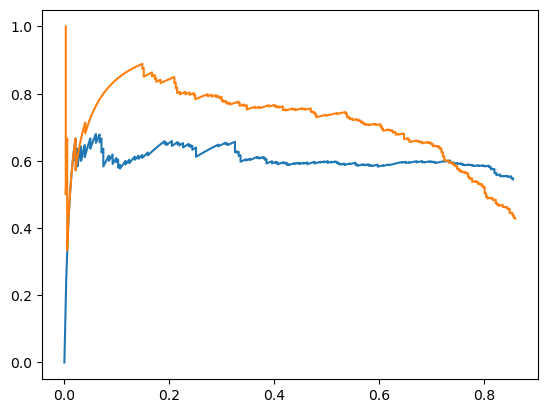

mAP list: [[0.5146621548499709, 0.6126077859382333]]


In [151]:
score = auc_pr_score(test_dataset_dicts, iou_thresh=[0.5], show_graph=True)
print(f"mAP list: {score}")

## Custom mAP COCO

Сomparison Bboxes: 


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Plotting PR-Curve:


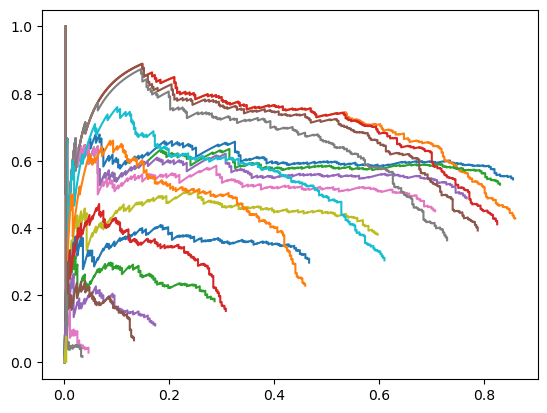

In [156]:
scores = auc_pr_score(test_dataset_dicts, iou_thresh=[i*0.01 for i in range(50, 96, 5)], show_graph=True)

In [153]:
print(f"mAP50: {np.mean(scores[0])}")
print(f"mAP COCO: {np.mean(scores)}")

mAP50: 0.5636349703941022
mAP COCO: 0.26460140949314587


## Evaluate mAP COCO from Detectron2

In [154]:
evaluator = COCOEvaluator("basketball_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "basketball_dataset_test")

COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


In [155]:
%%time
inference_on_dataset(predictor.model, val_loader, evaluator)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:

OrderedDict([('bbox',
              {'AP': 27.89442304188876,
               'AP50': 58.17036020392873,
               'AP75': 21.599984286937506,
               'APs': nan,
               'APm': 28.13653528677728,
               'APl': 28.672011506750767,
               'AP-team1': 31.249339992444437,
               'AP-team2': 24.53950609133308})])